In [1]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] RevoUtils_11.0.1     RevoUtilsMath_11.0.0

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.18         digest_0.6.15        crayon_1.3.4        
 [4] IRdisplay_0.5.0      repr_0.15.0          jsonlite_1.5        
 [7] magrittr_1.5         evaluate_0.11        stringi_1.1.7       
[10] uuid_0.1-2           IRkernel_0.8.12.9000 tools_3.5.1         
[13] stringr_1.3.1        compiler_3.5.1       base64enc_0.1-3     
[16] pbdZMQ_0.3-3         htmltools_0.3.6     

# Loading data

In [2]:
geno <-read.table("./Hetero_realigned_cov10_filtered3.raw", row.names=1, header=T)
row.names(geno)=1:240
x <- as.matrix(geno)-1   
pheno <- read.csv("./2017heteroPheno.csv", header=T)
attach(pheno)

#  The histgram of H. okamotoi count and the transformed data

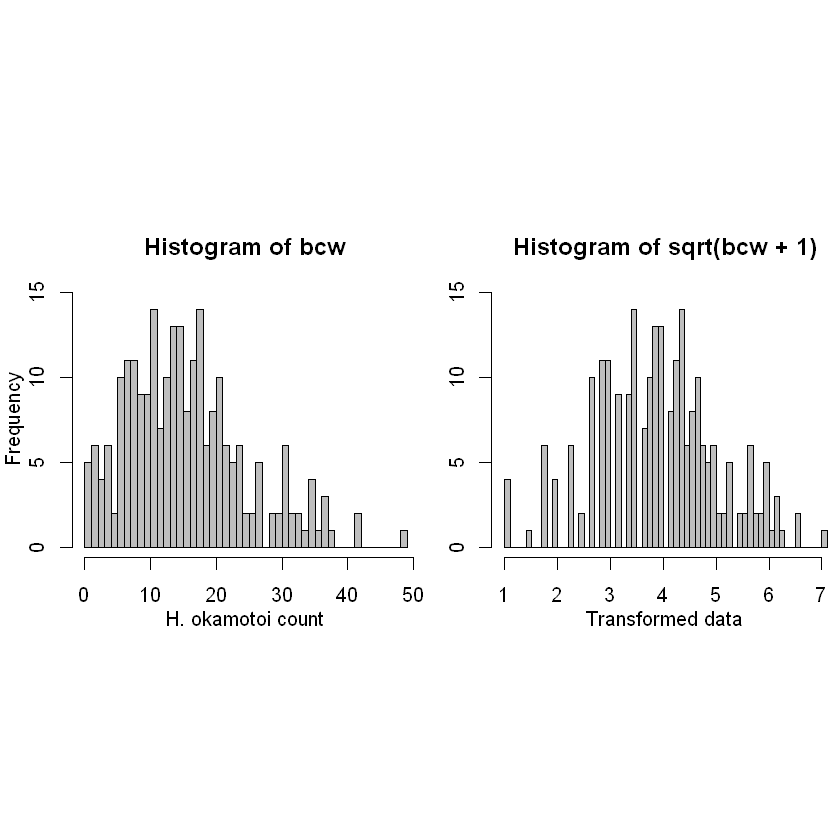

In [3]:
#pdf("plots.pdf")
par(mfrow=c(1,2),mgp=c(2,1,0),mar=c(3, 3, 3,0 ))
nf <- layout(matrix(c(1,2),ncol=2), widths=c(2,2), heights=c(2,2), TRUE)
hist(bcw,nclass=50, xlab = "H. okamotoi count",col="grey",ylim=c(0,15),cex.axis = 1,cex.lab=1)
hist(sqrt(bcw+1),nclass=50,col="grey",ylab="",ylim=c(0,15),cex.axis = 1,xlab = "Transformed data",cex.lab=1)
#dev.off()

# General statistics

In [4]:
library(rrBLUP)
packageVersion("rrBLUP")

[1] '4.6'

In [5]:
meanSD <- data.frame(bcw,length)
as.data.frame( t(sapply(meanSD, function(cl) list(mean=mean(cl,na.rm=TRUE),sd=sd(cl,na.rm=TRUE))) ))

,mean,sd
bcw,15.85417,9.165128
length,9.832917,0.779899


In [8]:
print(paste("phenotypic correlation",cor(bcw,length)))

[1] "phenotypic correlation 0.162936985198588"


# Heritability estimates for H. okamotoi count and body length. 

In [14]:
A <- A.mat(x, n.core=8)
data <- data.frame(tbcw=sqrt(pheno$bcw+1),length=pheno$length,gid=1:240,x=x)
row.names(A)=1:240;colnames(A)=1:240
ans_bcw <- kin.blup(data,geno="gid", pheno="tbcw",K=A)
ans_length <- kin.blup(data,geno="gid",pheno="length",K = A)
h2_bcw <- ans_bcw$Vg/(ans_bcw$Vg+ans_bcw$Ve)        
h2_length <- ans_length$Vg/(ans_length$Vg+ans_length$Ve)
print(paste("h2_bcw", h2_bcw))
print(paste("h2_length", h2_length))

[1] "h2_bcw 0.646466246472572"
[1] "h2_length 0.843382207016187"


#  Manhattan plots of GWAS study with Bonferroni-corrected significance thresholds

In [9]:
library(rrBLUP)
packageVersion("rrBLUP")

[1] '4.6'

In [15]:
A=A.mat(x)
lin_map<-read.table("./raw.map")
row.names(A)=1:240;colnames(A)=1:240
g <- data.frame(rownames(lin_map),lin_map$V1, lin_map$V2, t(x))
rownames(g) <-1:nrow(g)
colnames(g) <-c("marker", "chrom", "pos", rownames(x))
bcwframe <-data.frame(1:240, sqrt(pheno$bcw+1))
colnames(bcwframe) <-c("gid", "tbcw")
# perform GWAS with the GWAS function in the rrBLUP package
GWAS_bcw <-GWAS(bcwframe, g,K=A, n.PC = 10) 

[1] "GWAS for trait: tbcw"
[1] "Variance components estimated. Testing markers."


In [17]:
#SNP markers with lowest P-values
GWAS_bcw$chrom[head(order(GWAS_bcw$tbcw,decreasing = TRUE),3)]

[1] 4 9 1

In [19]:
GWAS_bcw$pos[head(order(GWAS_bcw$tbcw,decreasing = TRUE),3)]

[1]  8994840 12024615 13727873

[1] 4.895201

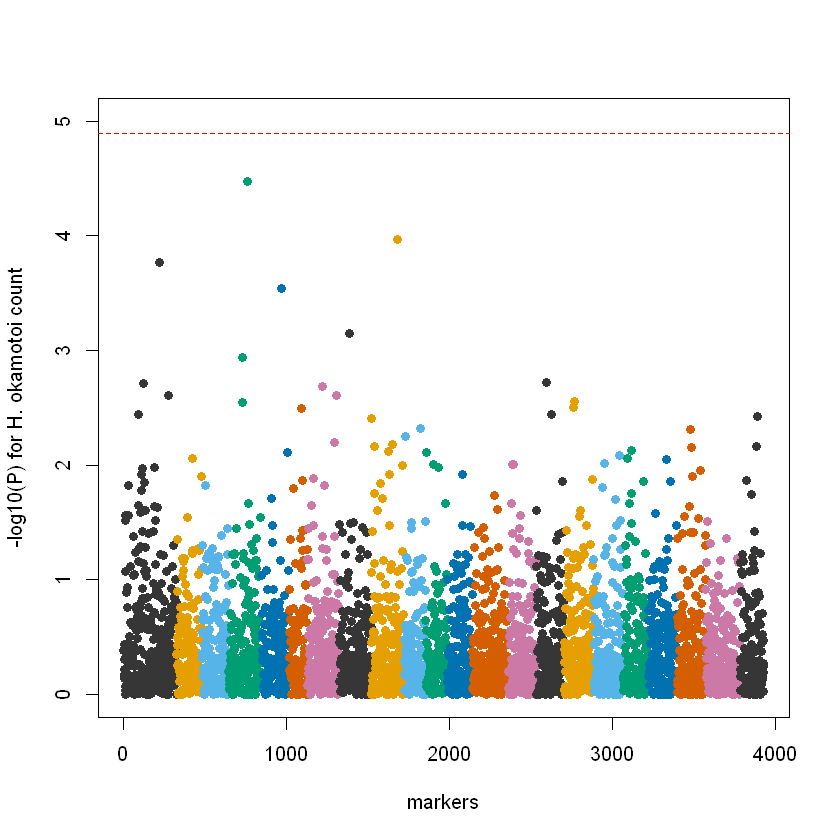

In [21]:
#manhatan plot
(thred <- -log10(0.05/nrow(g)))
cbPalette2 <- c("#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636", "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7",
                "#363636")

plot(GWAS_bcw$tbcw,col=cbPalette2[GWAS_bcw$chrom], pch=19, ylab="-log10(P) for H. okamotoi count",xlab="markers", ylim=c(0,5))
abline(h=thred, lty=2,col="red")